In [331]:
# Just for you to see, how I included the UPlift part in our algorithm. You can delte it afterwards

In [332]:
# # Train uplift tree
# uplift_model1 = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 10, min_samples_treatment = 10, 
#                                     n_reg = 2, evaluationFunction='CTS', control_name ='No Discount')

# uplift_model1.fit(dat_train[x_names].values,
#                  treatment=dat_train['treatment_group_key'].values,
#                  y=dat_train.y.values)
# uplift_model1

In [333]:
# pred = predict(uplift_model1,dat_test[x_names].values)
# pred

In [334]:
# column = pred[["No Discount","P_25","P_50","P_20","P_75"]]
# pred = pred.assign(max_value=column.max(1))
# pred["Uplift"]=pred.max_value - pred["No Discount"]
# pred = pred.drop(columns=["No Discount","P_25","P_50","P_20","P_75","max_value"])
# pred

# Importing Necessary Libraries

In [335]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt

In [336]:
import random
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [337]:
import causalml
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

# Definition of Functions

## 1. Error Function

In [338]:
def f(row):
    if row['treatment_group_key'] == row['predT'] and row['predY'] >= row['y']:
        val = 1
    elif row['treatment_group_key'] != row['predT'] and row['predY'] < row['y']:
        val = 1
    else:
        val = 0
    return val

## 2. Adaboost Uplift Algorithm

In [339]:
# Source: CausalML, but adapted
def predict(self, X, full_output=True):
        p_hat_optimal = []
        treatment_optimal = []
        pred_nodes = {}
        upliftScores = []
        for xi in range(len(X)):
            pred_leaf, upliftScore = self.classify(X[xi], self.fitted_uplift_tree, dataMissing=False)
            # Predict under uplift optimal treatment
            opt_treat = max(pred_leaf, key=pred_leaf.get)
            p_hat_optimal.append(pred_leaf[opt_treat])
            treatment_optimal.append(opt_treat)
            if full_output:
                if xi == 0:
                    for key_i in pred_leaf:
                        pred_nodes[key_i] = [pred_leaf[key_i]]
                else:
                    for key_i in pred_leaf:
                        pred_nodes[key_i].append(pred_leaf[key_i])
                upliftScores.append(upliftScore)
        treatment_optimal = pd.DataFrame(treatment_optimal)
        pred_nodes = pd.DataFrame(pred_nodes )
        New = pd.concat([treatment_optimal,pred_nodes],axis=1)
        New = New.rename({0:"recommended_treatment"},axis=1)
        
        if full_output:
            return New

        else:
            return New

In [340]:
# Source: CausalML, but adapted
def predictFor(self, X, full_output=False):
        df_res = pd.DataFrame()
        y_pred_ensemble = dict()
        y_pred_list = np.zeros((X.shape[0], len(self.classes_)))

        # Make prediction by each tree
        for tree_i in range(len(self.uplift_forest)):

            _, _, _, y_pred_full = self.uplift_forest[tree_i].predict(X=X, full_output=True)

            if tree_i == 0:
                for treatment_group in y_pred_full:
                    y_pred_ensemble[treatment_group] = (
                        np.array(y_pred_full[treatment_group]) / len(self.uplift_forest)
                    )
            else:
                for treatment_group in y_pred_full:
                    y_pred_ensemble[treatment_group] = (
                        np.array(y_pred_ensemble[treatment_group])
                        + np.array(y_pred_full[treatment_group]) / len(self.uplift_forest)
                    )

        # Summarize results into dataframe
        for treatment_group in y_pred_ensemble:
            df_res[treatment_group] = y_pred_ensemble[treatment_group]

        df_res['recommended_treatment'] = df_res.apply(np.argmax, axis=1)

        # Calculate delta
        delta_cols = []
        for treatment_group in y_pred_ensemble:
            if treatment_group != self.control_name:
                delta_cols.append('delta_%s' % (treatment_group))
                df_res['delta_%s' % (treatment_group)] = df_res[treatment_group] - df_res[self.control_name]
                # Add deltas to results list
                y_pred_list[:, self.classes_[treatment_group]] = df_res['delta_%s' % (treatment_group)].values
        df_res['max_delta'] = df_res[delta_cols].max(axis=1)

        return df_res

In [341]:
def adaboost_cts(data,test, M):
    global betaList
    betaList=[]
    global models
    models = []
    n_train = len(data)
    global PreY
    PreY = []
    global Total
    Total = []
    global betan
    betan = pd.DataFrame(pd.np.empty((len(test), 1)))
    global output


    
    for i in range(M):
        while i==0:
            input = data.copy()
            # Add weights
            input["weight"] = np.ones(len(input))/len(input)
            # Calculate uplift based on CTS
            uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 10, min_samples_treatment = 100, 
                                    n_reg = 1, evaluationFunction='CTS', control_name='No Discount')

            uplift_model.fit(input[x_names].values,
                 treatment=input['treatment_group_key'].values,
                 y=input['y'].values)
            #models.append(new)
            # Extract predictions for training data
            x_pred = np.transpose(pd.DataFrame(uplift_model.predict(input[x_names].values)))
            predictions = predict(uplift_model,test[x_names].values)
            
            # Add predictions to original data frame
            input = pd.concat([input.reset_index(drop='True'),x_pred.reset_index(drop='True')],axis=1)
            input = input.rename({0: 'predT', 1: 'predY'}, axis="columns")
        
            # Make and save predictions on test set
            y_pred = predict(uplift_model,test[x_names].values)
            column = y_pred[["No Discount","P_25","P_50","P_20","P_75"]]
            y_pred = y_pred.assign(max_value = column.max(1))
            y_pred["Uplift"]=y_pred.max_value - y_pred["No Discount"]
            y_pred = y_pred.drop(columns=["No Discount","P_25","P_50","P_20","P_75","max_value"])
            PreY.append(y_pred)
        
            # Calculate error of each observation (0 or 1)
            errors = input.apply(f, axis=1)

            # Model error
            e = ((errors*input.weight).sum())/(input.weight.sum()) # check that one again
            # Calculate weight of the whole model
            beta = np.exp(-3*e)
            # Add model weight to list
            betaList.append(beta)
            betan[0] = beta
            y_pred["beta"]=betan
            y_pred = y_pred[["beta","recommended_treatment","Uplift"]]
            Total.append(y_pred)

            
            # Change weights for each data point
            for i in range(len(input)):
                if errors[i] == 1: input.weight[i] = input.weight[i]* (1-0.5*beta)**-1
                else: input.weight[i]  = input.weight[i] * beta
            
            # Drop predictions columns so that they can be added in the next iteration again
            input = input.drop(columns=["predT","predY"])
            
            # Create new variable
            output = input.copy()
            
            
        while 0 < i < M :
            #input = random.choices(list(output), weights= output.weight, k = len(output))
            input = output.sample(weights = output.weight, n=len(output), replace=True, random_state=111)
            input.weight = np.ones(len(input))/len(input)
            uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 10, min_samples_treatment = 10, 
                                    n_reg = 1, evaluationFunction='CTS', control_name='No Discount')

            uplift_model.fit(input[x_names].values,
                 treatment=input['treatment_group_key'].values,
                 y=input['y'].values)
            #models.append(new)
            x_pred = np.transpose(pd.DataFrame(uplift_model.predict(input[x_names].values)))
            
            input = pd.concat([input.reset_index(drop='True'),x_pred.reset_index(drop='True')],axis=1)
            input = input.rename({0: 'predT', 1: 'predY'}, axis="columns")
            
            # Make and save predictions on test set
            y_pred = predict(uplift_model,test[x_names].values)
            column = y_pred[["No Discount","P_25","P_50","P_20","P_75"]]
            y_pred = y_pred.assign(max_value = column.max(1))
            y_pred["Uplift"]=y_pred.max_value - y_pred["No Discount"]
            y_pred = y_pred.drop(columns=["No Discount","P_25","P_50","P_20","P_75","max_value"])
            PreY.append(y_pred)
            
            errors = input.apply(f, axis=1)
           
            
            e = ((errors*input.weight).sum())/input.weight.sum() 
            beta = np.exp(-3*e)
            betaList.append(beta)
            betan[0] = beta
            y_pred["beta"]=betan
            y_pred = y_pred[["beta","recommended_treatment","Uplift"]]
            Total.append(y_pred)
        
        
            
            for i in range(len(input)):
                if errors[i] == 1: input.weight[i] = input.weight[i]* (1-0.5*beta)**-1
                else: input.weight[i]  = input.weight[i] * beta
        
            input =input.drop(columns=["predT","predY"])
            output = input.copy()

## 3. Recommended Treatment

In [342]:
def get_max_treatment(*args):
    global results
    results = []
    global df_all
    df_all = []
    for a in args:
       df_all.append(a)
    
    df_all = pd.concat(df_all)
    nrows = len(np.unique(df_all.index.to_list()))
    
    for i in range(nrows):
        results.append(df_all.loc[i].groupby(['recommended_treatment']).sum().sort_values(by=['beta'], ascending=False).index.to_list()[0])
        
    return results


## 4. Predicted Outcome under Optimal Treatment

In [343]:
def get_mean_y(df_all,results):
    global mean_y
    li = []
    mean_y = []
    #results = results.predT.to_list()
    for i in range(len(results)):
        d = df_all.loc[i][df_all.loc[i].recommended_treatment == results[i]]
        li.append(d)
        mean_y.append(li[i].Uplift.mean())
    
    mean_y = pd.DataFrame(mean_y)
    
    return mean_y

# Adaboost Uplift with Shoe Data Set

## 1. Loading the Data & Descriptive Statistics

In [344]:
file = "/Users/dorisscma/Desktop/HU Berlin/2nd Semester/Applied Predictive Analytics/APA_shoe.csv"
shoedat = pd.read_csv(file)
dat = shoedat.copy()
dat.describe()

,Unnamed: 0,campaignMov,checkoutAmount,lastSessionTimestamp,lastConversionTimestamp,treatmentGroup,MT_P_20,MT_P_25,MT_P_50,MT_P_75,MT_Control
count,133595.000000,133595.0,133595.000000,6.487100e+04,1.241300e+04,133595.000000,133595.000000,133595.000000,133595.000000,133595.000000,133595.000000
mean,66798.000000,0.0,369.815442,1.491698e+09,1.518005e+09,0.748524,0.083446,0.005479,0.584528,0.075070,0.251476
std,38565.698943,0.0,1873.830680,3.096297e+08,2.410816e+08,0.433863,0.276557,0.073819,0.492805,0.263506,0.433863
min,1.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33399.500000,0.0,0.000000,1.544569e+09,1.549795e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,66798.000000,0.0,0.000000,1.557262e+09,1.557576e+09,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,100196.500000,0.0,0.000000,1.563882e+09,1.562430e+09,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,133595.000000,0.0,74530.000000,1.574170e+09,1.574078e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [345]:
dat

,Unnamed: 0,campaignMov,checkoutAmount,converted,dropOff,confirmed,aborted,isMobile,zipCode,hadCartAdd,...,lastConversionTimestamp,initScreenType,channel,treatmentGroup,multi_treat,MT_P_20,MT_P_25,MT_P_50,MT_P_75,MT_Control
0,1,0,0,False,True,False,True,True,86405,False,...,NaN,home,SEARCH,1,P_50,0,0,1,0,0
1,2,0,0,False,False,False,False,True,78532,False,...,NaN,home,AFFILIATE,0,0,0,0,0,0,1
2,3,0,0,False,False,False,False,True,10369,False,...,NaN,product,AFFILIATE,1,P_50,0,0,1,0,0
3,4,0,0,False,False,False,False,True,86150,False,...,NaN,product,DIRECT,0,0,0,0,0,0,1
4,5,0,0,False,False,False,False,True,32549,False,...,NaN,overview,DIRECT,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133590,133591,0,0,False,False,False,False,True,70499,False,...,NaN,home,SEARCH,0,0,0,0,0,0,1
133591,133592,0,0,False,False,False,False,True,51429,False,...,NaN,home,DIRECT,1,P_20,1,0,0,0,0
133592,133593,0,0,False,False,False,True,True,50937,False,...,NaN,home,SEARCH,1,P_20,1,0,0,0,0
133593,133594,0,0,False,False,False,True,True,49152,False,...,NaN,home,SEARCH,1,P_20,1,0,0,0,0


In [346]:
dat.columns.values

array(['Unnamed: 0', 'campaignMov', 'checkoutAmount', 'converted',
       'dropOff', 'confirmed', 'aborted', 'isMobile', 'zipCode',
       'hadCartAdd', 'clientKnown', 'lastSessionTimestamp',
       'lastConversionTimestamp', 'initScreenType', 'channel',
       'treatmentGroup', 'multi_treat', 'MT_P_20', 'MT_P_25', 'MT_P_50',
       'MT_P_75', 'MT_Control'], dtype=object)

In [347]:
dat.channel.value_counts()

SEARCH         66535
DIRECT         38238
INTERNAL       20306
AFFILIATE       3921
RETARGETING     2334
PAID            1747
SOCIAL           355
EMAIL            159
Name: channel, dtype: int64

In [348]:
dat.multi_treat.value_counts()

P_50    78090
0       33596
P_20    11148
P_75    10029
P_25      732
Name: multi_treat, dtype: int64

In [349]:
pd.crosstab(dat.multi_treat, dat.converted)

converted,False,True
multi_treat,,
0,31307,2289
P_20,10315,833
P_25,682,50
P_50,72793,5297
P_75,9263,766


In [350]:
dat.groupby([dat.multi_treat]).sum()

,Unnamed: 0,campaignMov,checkoutAmount,converted,dropOff,confirmed,aborted,isMobile,hadCartAdd,clientKnown,lastSessionTimestamp,lastConversionTimestamp,treatmentGroup,MT_P_20,MT_P_25,MT_P_50,MT_P_75,MT_Control
multi_treat,,,,,,,,,,,,,,,,,,
0,2240981314,0,12208169,2289.0,4557.0,0.0,4.0,27718.0,6082.0,16235.0,2.422358e+13,4.732768e+12,0,0,0,0,0,33596
P_20,1399110167,0,4871826,833.0,1451.0,426.0,5621.0,8370.0,2044.0,5184.0,7.901663e+12,1.475061e+12,11148,11148,0,0,0,0
P_25,93555938,0,354214,50.0,93.0,59.0,411.0,534.0,127.0,317.0,4.857039e+11,9.357245e+10,732,0,732,0,0,0
P_50,4361293471,0,27767620,5297.0,9836.0,3145.0,39167.0,64762.0,14173.0,37752.0,5.613446e+13,1.086307e+13,78090,0,0,78090,0,0
P_75,828937920,0,4203665,766.0,921.0,1515.0,3498.0,8781.0,2117.0,5383.0,8.022505e+12,1.678521e+12,10029,0,0,0,10029,0


## 2. Preparation of the Data

In [351]:
# Change the amount of money from cents to euros
dat.checkoutAmount = dat.checkoutAmount.values/100
dat.describe()

,Unnamed: 0,campaignMov,checkoutAmount,lastSessionTimestamp,lastConversionTimestamp,treatmentGroup,MT_P_20,MT_P_25,MT_P_50,MT_P_75,MT_Control
count,133595.000000,133595.0,133595.000000,6.487100e+04,1.241300e+04,133595.000000,133595.000000,133595.000000,133595.000000,133595.000000,133595.000000
mean,66798.000000,0.0,3.698154,1.491698e+09,1.518005e+09,0.748524,0.083446,0.005479,0.584528,0.075070,0.251476
std,38565.698943,0.0,18.738307,3.096297e+08,2.410816e+08,0.433863,0.276557,0.073819,0.492805,0.263506,0.433863
min,1.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33399.500000,0.0,0.000000,1.544569e+09,1.549795e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,66798.000000,0.0,0.000000,1.557262e+09,1.557576e+09,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,100196.500000,0.0,0.000000,1.563882e+09,1.562430e+09,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,133595.000000,0.0,745.300000,1.574170e+09,1.574078e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [352]:
dat['multi_treat'] = np.where(dat['multi_treat'] == "0", "No Discount", dat['multi_treat'])
dat.head()

,Unnamed: 0,campaignMov,checkoutAmount,converted,dropOff,confirmed,aborted,isMobile,zipCode,hadCartAdd,...,lastConversionTimestamp,initScreenType,channel,treatmentGroup,multi_treat,MT_P_20,MT_P_25,MT_P_50,MT_P_75,MT_Control
0,1,0,0.0,False,True,False,True,True,86405,False,...,NaN,home,SEARCH,1,P_50,0,0,1,0,0
1,2,0,0.0,False,False,False,False,True,78532,False,...,NaN,home,AFFILIATE,0,No Discount,0,0,0,0,1
2,3,0,0.0,False,False,False,False,True,10369,False,...,NaN,product,AFFILIATE,1,P_50,0,0,1,0,0
3,4,0,0.0,False,False,False,False,True,86150,False,...,NaN,product,DIRECT,0,No Discount,0,0,0,0,1
4,5,0,0.0,False,False,False,False,True,32549,False,...,NaN,overview,DIRECT,0,No Discount,0,0,0,0,1


In [353]:
dat = dat.rename({"multi_treat": 'treatment_group_key'}, axis="columns")
dat = dat[['hadCartAdd','clientKnown','initScreenType',"channel","lastConversionTimestamp","lastSessionTimestamp",'treatment_group_key',"checkoutAmount","converted"]]
dat = dat.rename({"checkoutAmount": 'y'}, axis="columns")

In [354]:
dat=dat.fillna(0)
dat.head()

,hadCartAdd,clientKnown,initScreenType,channel,lastConversionTimestamp,lastSessionTimestamp,treatment_group_key,y,converted
0,False,True,home,SEARCH,0.0,1.562230e+09,P_50,0.0,False
1,False,False,home,AFFILIATE,0.0,0.000000e+00,No Discount,0.0,False
2,False,True,product,AFFILIATE,0.0,1.560770e+09,P_50,0.0,False
3,False,True,product,DIRECT,0.0,1.561925e+09,No Discount,0.0,False
4,False,False,overview,DIRECT,0.0,0.000000e+00,No Discount,0.0,False


In [355]:
dat.describe()

,lastConversionTimestamp,lastSessionTimestamp,y
count,1.335950e+05,1.335950e+05,133595.000000
mean,1.410456e+08,7.243378e+08,3.698154
std,4.467834e+08,7.761342e+08,18.738307
min,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000
50%,0.000000e+00,0.000000e+00,0.000000
75%,0.000000e+00,1.556815e+09,0.000000
max,1.574078e+09,1.574170e+09,745.300000


In [356]:
# Dummy coding of some of the variables
dat = pd.get_dummies(data = dat, columns=['initScreenType',"channel","hadCartAdd","clientKnown"])
x_names = dat.keys()
x_names = x_names.drop(["y","treatment_group_key"])
x_names

Index(['lastConversionTimestamp', 'lastSessionTimestamp', 'converted',
       'initScreenType_about', 'initScreenType_account',
       'initScreenType_basket', 'initScreenType_billing',
       'initScreenType_checkout', 'initScreenType_home',
       'initScreenType_order', 'initScreenType_other',
       'initScreenType_overview', 'initScreenType_payment',
       'initScreenType_product', 'initScreenType_sale',
       'initScreenType_search', 'initScreenType_shipping', 'channel_AFFILIATE',
       'channel_DIRECT', 'channel_EMAIL', 'channel_INTERNAL', 'channel_PAID',
       'channel_RETARGETING', 'channel_SEARCH', 'channel_SOCIAL',
       'hadCartAdd_False', 'hadCartAdd_True', 'clientKnown_False',
       'clientKnown_True'],
      dtype='object')

## 3. Building the Model

In [357]:
# Split data to training and testing samples for model validation (next section)
dat_train, dat_test= train_test_split(dat, test_size=0.2, random_state=111)
dat_train.head()

,lastConversionTimestamp,lastSessionTimestamp,treatment_group_key,y,converted,initScreenType_about,initScreenType_account,initScreenType_basket,initScreenType_billing,initScreenType_checkout,...,channel_EMAIL,channel_INTERNAL,channel_PAID,channel_RETARGETING,channel_SEARCH,channel_SOCIAL,hadCartAdd_False,hadCartAdd_True,clientKnown_False,clientKnown_True
74769,0.000000e+00,0.000000e+00,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
12259,1.560153e+09,1.559317e+09,P_50,0.0,False,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2625,0.000000e+00,1.556704e+09,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
104537,0.000000e+00,0.000000e+00,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
60913,0.000000e+00,1.544359e+09,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1


In [359]:
# Run the model
adaboost_cts(data=dat_train, test=dat_test, M=6)

In [360]:
# Overview over betas of each round
betaList

[0.6921778504817854,
 0.44089888928212057,
 0.45121555814731373,
 0.405279829215145,
 0.4781562783133412,
 0.43715259407236357]

In [361]:
# You have to choose here the one similar to the "M" chosen in the adaboost formula. 

In [362]:
# # 1 round
# d1 = Total[0]

In [363]:
# # 3 rounds
# d1 = Total[0]
# d2 = Total[1]
# d3 = Total[2]

In [364]:
# 6 rounds
d1 = Total[0]
d2 = Total[1]
d3 = Total[2]
d4 = Total[3]
d5 = Total[4]
d6 = Total[5]

In [365]:
# # 8 rounds
# d1 = Total[0]
# d2 = Total[1]
# d3 = Total[2]
# d4 = Total[3]
# d5 = Total[4]
# d6 = Total[5]
# d7 = Total[6]
# d8 = Total[7]

In [366]:
# # 12 rounds
# d1 = Total[0]
# d2 = Total[1]
# d3 = Total[2]
# d4 = Total[3]
# d5 = Total[4]
# d6 = Total[5]
# d7 = Total[6]
# d8 = Total[7]
# d9 = Total[8]
# d10 = Total[9]
# d11= Total[10]
# d12= Total[11]
# result = get_max_treatment(d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12)

In [367]:
# # 15 rounds
# d1 = Total[0]
# d2 = Total[1]
# d3 = Total[2]
# d4 = Total[3]
# d5 = Total[4]
# d6 = Total[5]
# d7 = Total[6]
# d8 = Total[7]
# d9 = Total[8]
# d10 = Total[9]
# d11= Total[10]
# d12= Total[11]
# d13 = Total[12]
# d14= Total[13]
# d15= Total[14]

# result = get_max_treatment(d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12)

In [368]:
# # Get max treatment if m=1
# results=d1.recommended_treatment

In [369]:
# # Get max treatment if m=3
# results=get_max_treatment(d1,d2,d3)

In [370]:
# Get max treatment if m=6
results=get_max_treatment(d1,d2,d3,d4,d5,d6)

In [371]:
# # Get max treatment if m=8
# results=get_max_treatment(d1,d2,d3,d4,d5,d6,d7,d8)

In [372]:
# # Get max treatment if m=12
# results=get_max_treatment(d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12)

In [373]:
# # Get max treatment if m=15
# results=get_max_treatment(d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15)

In [374]:
# Get the predicted y value per person
get_mean_y(df_all,results)

,0
0,4.877818
1,9.413077
2,5.213085
3,4.877818
4,1.259023
...,...
26714,14.222161
26715,9.413077
26716,14.731710
26717,3.086489


In [375]:
# Just to see predictions of one person (VALUES GETTING BIGGER AND BIGGER EACH ROUND...)
df_all.loc[29]

,beta,recommended_treatment,Uplift
29,0.692178,P_20,1.403098
29,0.440899,P_50,0.000000
29,0.451216,No Discount,0.000000
29,0.405280,P_25,13.337698
29,0.478156,P_50,9.755636
29,0.437153,P_75,18.203176


In [376]:
mean_y

,0
0,4.877818
1,9.413077
2,5.213085
3,4.877818
4,1.259023
...,...
26714,14.222161
26715,9.413077
26716,14.731710
26717,3.086489


# Evaluation of the Model

## 1. Overview of Results of Adaboost Uplift

In [377]:
# Create dataframe that contains all the results
table_uplift = pd.concat([pd.DataFrame(results),pd.DataFrame(mean_y)],axis=1)
table_uplift.columns= ["Predicted treatment","Predicted y"]
table_uplift

,Predicted treatment,Predicted y
0,P_50,4.877818
1,P_75,9.413077
2,P_50,5.213085
3,P_50,4.877818
4,P_20,1.259023
...,...,...
26714,P_25,14.222161
26715,P_75,9.413077
26716,P_25,14.731710
26717,P_20,3.086489


In [378]:
dat_test.treatment_group_key

18397            P_50
61127     No Discount
131186           P_20
19039            P_50
44143            P_50
             ...     
108691           P_50
36359            P_50
124953           P_20
78801     No Discount
14658     No Discount
Name: treatment_group_key, Length: 26719, dtype: object

In [379]:
new1 = dat_test.y.reset_index(drop=True)
new2 = dat_test.treatment_group_key.reset_index(drop=True)

## 2. Benchmark Models

### Conctextual Treatment Selection (CTS)

In [49]:
# Train uplift tree
uplift_model1 = UpliftRandomForestClassifier(n_estimators=10,max_depth = 4, min_samples_leaf = 10, 
                                             min_samples_treatment = 100, n_reg = 1, evaluationFunction='CTS', 
                                             control_name ='No Discount')

uplift_model1.fit(dat_train[x_names].values,
                 treatment=dat_train['treatment_group_key'].values,
                 y=dat_train.y.values)
uplift_model1


In [50]:
# Predict using the build CTS Model
predictions = predictFor(uplift_model1,dat_test[x_names].values)
predictions

,P_50,P_25,P_20,P_75,No Discount,recommended_treatment,delta_P_50,delta_P_25,delta_P_20,delta_P_75,max_delta
0,3.317303,3.550869,4.008616,3.150541,3.186562,2,0.130741,0.364307,0.822055,-0.036021,0.822055
1,3.402683,3.035187,4.265091,3.863355,3.470278,2,-0.067595,-0.435091,0.794813,0.393077,0.794813
2,3.504815,2.678155,4.211678,3.895610,3.596503,2,-0.091688,-0.918348,0.615174,0.299107,0.615174
3,3.130492,2.302630,4.182133,3.435934,3.147579,2,-0.017087,-0.844949,1.034554,0.288355,1.034554
4,3.833706,4.102410,4.799116,3.748102,3.751343,2,0.082364,0.351067,1.047774,-0.003241,1.047774
...,...,...,...,...,...,...,...,...,...,...,...
26714,3.737837,4.780024,4.282006,3.655052,3.630272,1,0.107565,1.149752,0.651734,0.024780,1.149752
26715,3.486357,3.615197,4.197865,4.155870,3.637066,2,-0.150708,-0.021869,0.560800,0.518804,0.560800
26716,3.312625,2.734525,4.291514,3.827041,3.369114,2,-0.056488,-0.634589,0.922401,0.457927,0.922401
26717,3.241167,2.932645,3.983896,3.846763,3.325440,2,-0.084273,-0.392795,0.658456,0.521323,0.658456


In [51]:
CTS_tr_map = {0:'P_75',1:'No Discount',2:'P_25',3:'P_20',4:'P_50'}
predictions = predictions.replace({"recommended_treatment": CTS_tr_map})
Pred_CTS = pd.DataFrame(predictions, columns=["recommended_treatment","max_delta"])
Pred_CTS = Pred_CTS.rename({"max_delta":"Uplift CTS"},axis=1)
Pred_CTS

,recommended_treatment,Uplift CTS
0,P_25,0.822055
1,P_25,0.794813
2,P_25,0.615174
3,P_25,1.034554
4,P_25,1.047774
...,...,...
26714,No Discount,1.149752
26715,P_25,0.560800
26716,P_25,0.922401
26717,P_25,0.658456


In [52]:
treat = Pred_CTS.recommended_treatment
ycts = Pred_CTS["Uplift CTS"]

### Separate Model Approach (SMA)

In [53]:
dat.columns

Index(['lastConversionTimestamp', 'lastSessionTimestamp',
       'treatment_group_key', 'y', 'converted', 'initScreenType_about',
       'initScreenType_account', 'initScreenType_basket',
       'initScreenType_billing', 'initScreenType_checkout',
       'initScreenType_home', 'initScreenType_order', 'initScreenType_other',
       'initScreenType_overview', 'initScreenType_payment',
       'initScreenType_product', 'initScreenType_sale',
       'initScreenType_search', 'initScreenType_shipping', 'channel_AFFILIATE',
       'channel_DIRECT', 'channel_EMAIL', 'channel_INTERNAL', 'channel_PAID',
       'channel_RETARGETING', 'channel_SEARCH', 'channel_SOCIAL',
       'hadCartAdd_False', 'hadCartAdd_True', 'clientKnown_False',
       'clientKnown_True'],
      dtype='object')

In [54]:
# Separate control and the different treatment groups
Control = dat_train[dat_train["treatment_group_key"]=='No Discount']
Tr1 = dat_train[dat_train["treatment_group_key"]=='P_20'] 
Tr2 = dat_train[dat_train["treatment_group_key"]=='P_25'] 
Tr3 = dat_train[dat_train["treatment_group_key"]=='P_50'] 
Tr4 = dat_train[dat_train["treatment_group_key"]=='P_75'] 

In [55]:
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [100, 200, 300], 'max_depth': [None, 1, 2, 3], 'min_samples_split': [1, 2, 3]}

clf0 = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf1 = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf2 = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf3 = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf4 = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf0 = clf0.fit(Control[x_names], Control.y.values)
clf1 = clf1.fit(Tr1[x_names], Tr1.y.values)
clf2 = clf2.fit(Tr2[x_names], Tr2.y.values)
clf3 = clf3.fit(Tr3[x_names], Tr3.y.values)
clf4 = clf4.fit(Tr3[x_names], Tr3.y.values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   41.1s finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   23.4s finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


In [56]:
# # Set the parameters by cross-validation
# tuned_parameters = {'n_estimators': [100, 200, 500], 'max_depth': [None, 1, 2, 3], 'min_samples_split': [1, 2, 3]}

# clf = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, cv=5, 
#                    n_jobs=-1, verbose=1)
# clf0 = clf.fit(Control[x_names], Control.y.values)
# clf1 = clf.fit(Tr1[x_names], Tr1.y.values)
# clf2 = clf.fit(Tr2[x_names], Tr2.y.values)
# clf3 = clf.fit(Tr3[x_names], Tr3.y.values)
# clf4 = clf.fit(Tr3[x_names], Tr3.y.values)

In [114]:
# Control
pr0 = pd.DataFrame(clf0.predict(dat_test[x_names].values))
# Tr1
pr1 = pd.DataFrame(clf1.predict(dat_test[x_names].values))
# Tr2
pr2 = pd.DataFrame(clf2.predict(dat_test[x_names].values))
# Tr3
pr3 = pd.DataFrame(clf3.predict(dat_test[x_names].values))
# Tr4
pr4 = pd.DataFrame(clf4.predict(dat_test[x_names].values))

In [115]:
SMA = pd.concat([pr0,pr1,pr2,pr3,pr4],axis=1)
SMA.columns = ["No_Discount","P_20","P_25","P_50","P_75"]
SMA['recommended_treat_SMA'] = SMA.idxmax(axis=1)
SMA

,No_Discount,P_20,P_25,P_50,P_75,recommended_treat_SMA
0,0.0,0.0,0.0,0.0,0.0,No_Discount
1,0.0,0.0,0.0,0.0,0.0,No_Discount
2,0.0,0.0,0.0,0.0,0.0,No_Discount
3,0.0,0.0,0.0,0.0,0.0,No_Discount
4,0.0,0.0,0.0,0.0,0.0,No_Discount
...,...,...,...,...,...,...
26714,0.0,0.0,0.0,0.0,0.0,No_Discount
26715,0.0,0.0,0.0,0.0,0.0,No_Discount
26716,0.0,0.0,0.0,0.0,0.0,No_Discount
26717,0.0,0.0,0.0,0.0,0.0,No_Discount


In [116]:
column = SMA[["No_Discount","P_25","P_50","P_20","P_75"]]
SMA = SMA.assign(max_value = column.max(1))
SMA["Uplift SMA"]=SMA.max_value - SMA["No_Discount"]
SMA = SMA.drop(columns=["No_Discount","P_25","P_50","P_20","P_75","max_value"])
SMA

,recommended_treat_SMA,Uplift SMA
0,No_Discount,0.0
1,No_Discount,0.0
2,No_Discount,0.0
3,No_Discount,0.0
4,No_Discount,0.0
...,...,...
26714,No_Discount,0.0
26715,No_Discount,0.0
26716,No_Discount,0.0
26717,No_Discount,0.0


In [118]:
SMA['recommended_treat_SMA'][SMA.recommended_treat_SMA == 'No_Discount'] = 'No Discount'

In [163]:
SMA.describe()

,Uplift SMA
count,26719.000000
mean,0.685928
std,3.663041
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,37.028494


## 3. Comparison of the Models

In [380]:
# Start building a table to have an overview
# table_uplift = pd.concat([table_uplift,ycts,treat,new1,new2], axis=1)
table_uplift = pd.concat([table_uplift,ycts,treat,SMA,new1,new2], axis=1)

table_uplift = table_uplift.head(26719)
table_uplift

,Predicted treatment,Predicted y,Uplift CTS,recommended_treatment,recommended_treat_SMA,Uplift SMA,y,treatment_group_key
0,P_50,4.877818,0.822055,P_25,No Discount,0.0,0.0,P_50
1,P_75,9.413077,0.794813,P_25,No Discount,0.0,0.0,No Discount
2,P_50,5.213085,0.615174,P_25,No Discount,0.0,0.0,P_20
3,P_50,4.877818,1.034554,P_25,No Discount,0.0,0.0,P_50
4,P_20,1.259023,1.047774,P_25,No Discount,0.0,0.0,P_50
...,...,...,...,...,...,...,...,...
26714,P_25,14.222161,1.149752,No Discount,No Discount,0.0,0.0,P_50
26715,P_75,9.413077,0.560800,P_25,No Discount,0.0,0.0,P_50
26716,P_25,14.731710,0.922401,P_25,No Discount,0.0,0.0,P_20
26717,P_20,3.086489,0.658456,P_25,No Discount,0.0,0.0,No Discount


In [381]:
table_uplift.columns = ["PredictedTreatment","Predicted Uplift",
                        "CTS Uplift","CTS treatment",
                        "SMA treatment","SMA Uplift",
                        "Real Spending","RealTreatment"]

#table_uplift.columns = ["PredictedTreatment","Predicted Uplift",
#                         "CTS Uplift","CTS treatment",
#                         "SMA Uplift",
#                         "Real Spending","RealTreatment"]
table_uplift

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment
0,P_50,4.877818,0.822055,P_25,No Discount,0.0,0.0,P_50
1,P_75,9.413077,0.794813,P_25,No Discount,0.0,0.0,No Discount
2,P_50,5.213085,0.615174,P_25,No Discount,0.0,0.0,P_20
3,P_50,4.877818,1.034554,P_25,No Discount,0.0,0.0,P_50
4,P_20,1.259023,1.047774,P_25,No Discount,0.0,0.0,P_50
...,...,...,...,...,...,...,...,...
26714,P_25,14.222161,1.149752,No Discount,No Discount,0.0,0.0,P_50
26715,P_75,9.413077,0.560800,P_25,No Discount,0.0,0.0,P_50
26716,P_25,14.731710,0.922401,P_25,No Discount,0.0,0.0,P_20
26717,P_20,3.086489,0.658456,P_25,No Discount,0.0,0.0,No Discount


In [382]:
# make all P_X to "T" and all No Discount to "C"
tr_map = {"P_20":1,"P_50":1,"P_75":1,"P_25":1,"No Discount":0}

table_uplift_nonModified = table_uplift.copy()
table_uplift_nonModified = table_uplift_nonModified.replace({"PredictedTreatment":tr_map})
table_uplift_nonModified = table_uplift_nonModified.replace({"CTS treatment":tr_map})
table_uplift_nonModified = table_uplift_nonModified.replace({"SMA treatment":tr_map})
table_uplift_nonModified = table_uplift_nonModified.replace({"RealTreatment":tr_map})
table_uplift_nonModified

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment
0,1,4.877818,0.822055,1,0,0.0,0.0,1
1,1,9.413077,0.794813,1,0,0.0,0.0,0
2,1,5.213085,0.615174,1,0,0.0,0.0,1
3,1,4.877818,1.034554,1,0,0.0,0.0,1
4,1,1.259023,1.047774,1,0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
26714,1,14.222161,1.149752,0,0,0.0,0.0,1
26715,1,9.413077,0.560800,1,0,0.0,0.0,1
26716,1,14.731710,0.922401,1,0,0.0,0.0,1
26717,1,3.086489,0.658456,1,0,0.0,0.0,0


In [162]:
table_uplift_nonModified['SMA treatment'].value_counts()

0    24880
1     1839
Name: SMA treatment, dtype: int64

### Qini curve

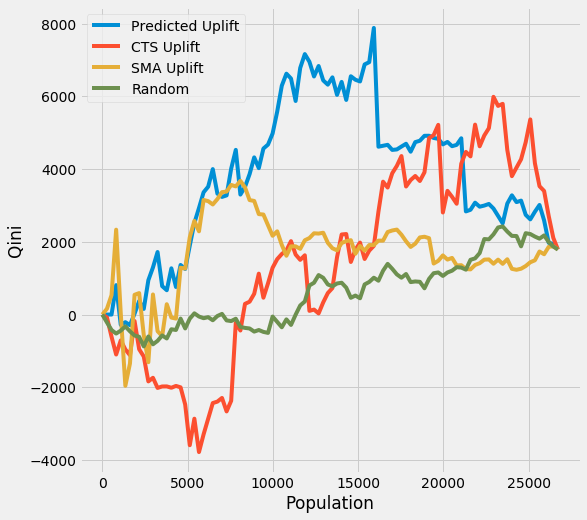

In [383]:
causalml.metrics.plot_qini(table_uplift_nonModified[['Predicted Uplift','CTS Uplift','SMA Uplift',
                                                     "Real Spending",'RealTreatment',
                                                    ]], 
                           outcome_col = "Real Spending",
                           treatment_col = "RealTreatment",
                           n = 100,
                           figsize=(8, 8))

### Gain curve

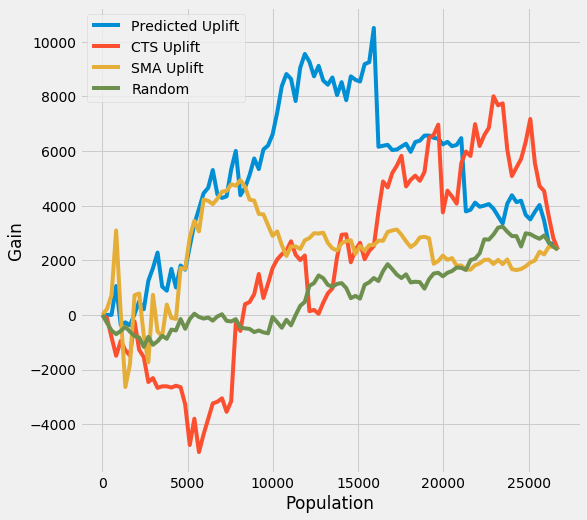

In [384]:
causalml.metrics.plot_gain(table_uplift_nonModified[['Predicted Uplift','CTS Uplift','SMA Uplift',
                                                     "Real Spending",'RealTreatment']], 
                           outcome_col = "Real Spending",
                           treatment_col = "RealTreatment",
                           figsize=(8, 8))

### Lift Curve

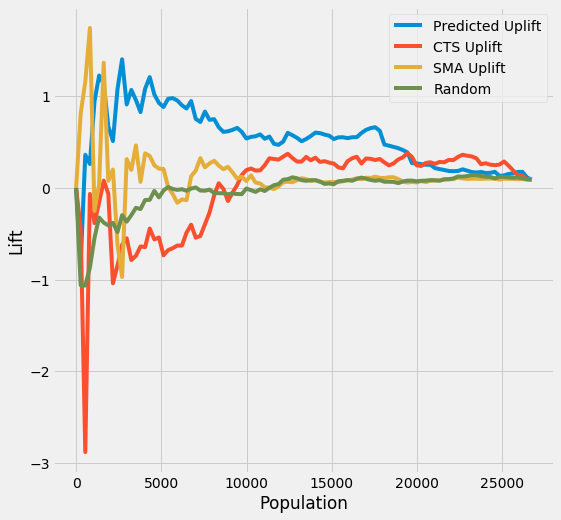

In [126]:
causalml.metrics.plot_lift(table_uplift_nonModified[['Predicted Uplift','CTS Uplift','SMA Uplift',
                                                     "Real Spending",'RealTreatment']], 
                           outcome_col = "Real Spending",
                           treatment_col = "RealTreatment",
                           figsize=(8, 8))

### Modified Uplift Curve

In [127]:
table_uplift

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment
0,P_50,8.865792,0.822055,P_25,No Discount,0.0,0.0,P_50
1,P_75,9.413077,0.794813,P_25,No Discount,0.0,0.0,No Discount
2,P_50,12.403205,0.615174,P_25,No Discount,0.0,0.0,P_20
3,P_20,2.836487,1.034554,P_25,No Discount,0.0,0.0,P_50
4,P_20,1.259023,1.047774,P_25,No Discount,0.0,0.0,P_50
...,...,...,...,...,...,...,...,...
26714,P_25,13.033277,1.149752,No Discount,No Discount,0.0,0.0,P_50
26715,P_75,9.413077,0.560800,P_25,No Discount,0.0,0.0,P_50
26716,P_20,2.836487,0.922401,P_25,No Discount,0.0,0.0,P_20
26717,P_20,3.480951,0.658456,P_25,No Discount,0.0,0.0,No Discount


In [128]:
pd.DataFrame(table_uplift.RealTreatment.value_counts(normalize=True))

,RealTreatment
P_50,0.585164
No Discount,0.251319
P_20,0.082076
P_75,0.075864
P_25,0.005577


In [129]:
tr_prob = pd.DataFrame(table_uplift.RealTreatment.value_counts(normalize=True))['RealTreatment'].to_dict() 
tr_prob

{'P_50': 0.5851641154234815,
 'No Discount': 0.25131928590141844,
 'P_20': 0.08207642501590628,
 'P_75': 0.07586361765036116,
 'P_25': 0.005576556008832666}

In [130]:
for treatment in tr_prob:
    print(treatment,'{}:'.format(tr_prob[treatment]))


P_50 0.5851641154234815:
No Discount 0.25131928590141844:
P_20 0.08207642501590628:
P_75 0.07586361765036116:
P_25 0.005576556008832666:


In [131]:
tr_prob

{'P_50': 0.5851641154234815,
 'No Discount': 0.25131928590141844,
 'P_20': 0.08207642501590628,
 'P_75': 0.07586361765036116,
 'P_25': 0.005576556008832666}

In [132]:
df_reverse

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment,prob_PredictedTreatment,Zt_PredictedTreatment,Ztotal_PredictedTreatment,Zbar_PredictedTreatment,prob_CTS treatment,Zt_CTS treatment,Zc_CTS treatment
0,P_50,4.877818,0.332896,P_25,No_Discount,0.0,0.0,P_50,0.585164,0.0,0.0,30.843273,0.005577,0.0,0.0
1,P_50,4.877818,0.332896,P_25,No_Discount,0.0,0.0,No Discount,0.585164,0.0,0.0,30.669996,0.005577,0.0,0.0
2,P_50,4.877818,0.332896,P_25,No_Discount,0.0,0.0,P_50,0.585164,0.0,0.0,30.822504,0.005577,0.0,0.0
3,P_50,4.877818,0.332896,P_25,No_Discount,0.0,0.0,P_50,0.585164,0.0,0.0,30.806547,0.005577,0.0,0.0
4,P_50,4.877818,0.332896,P_25,No_Discount,0.0,0.0,No Discount,0.585164,0.0,0.0,30.761955,0.005577,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26714,P_25,13.033277,1.149752,No Discount,No_Discount,0.0,0.0,P_50,0.005577,0.0,0.0,16.724243,0.251319,0.0,0.0
26715,P_25,13.033277,1.149752,No Discount,No_Discount,0.0,0.0,P_50,0.005577,0.0,0.0,16.728154,0.251319,0.0,0.0
26716,P_25,13.033277,1.149752,No Discount,No_Discount,0.0,0.0,No Discount,0.005577,0.0,0.0,16.732067,0.251319,0.0,0.0
26717,P_25,13.033277,1.149752,No Discount,No_Discount,0.0,0.0,P_50,0.005577,0.0,0.0,16.329918,0.251319,0.0,0.0


In [292]:
tr_prob

{'P_50': 0.5851641154234815,
 'No Discount': 0.25131928590141844,
 'P_20': 0.08207642501590628,
 'P_75': 0.07586361765036116,
 'P_25': 0.005576556008832666}

In [313]:
tr_prob['No Discount']

0.25131928590141844

In [301]:
df1['prob_PredictedTreatment'] = df['PredictedTreatment'].replace(tr_prob)
df1

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment,prob_PredictedTreatment,Zt_PredictedTreatment,Ztotal_PredictedTreatment,Zbar_PredictedTreatment
1,P_20,29.802597,1.029015,P_20,No Discount,0.0,0.0,P_50,0.075864,0.0,100174.962338,100174.962338
2,P_20,29.802597,1.029015,P_20,No Discount,0.0,0.0,P_50,0.585164,0.0,100174.962338,100174.962338
3,P_20,29.802597,1.029015,P_20,No Discount,0.0,0.0,P_50,0.082076,0.0,100174.962338,100174.962338
4,P_20,29.802597,1.029015,P_20,No Discount,0.0,0.0,P_50,0.082076,0.0,100174.962338,100174.962338
5,P_20,29.802597,0.833137,P_20,No Discount,0.0,0.0,P_50,0.005577,0.0,100174.962338,100174.962338
...,...,...,...,...,...,...,...,...,...,...,...,...
26715,No Discount,0.000000,1.029015,P_20,No Discount,0.0,0.0,P_20,0.075864,0.0,0.000000,50722.257241
26716,No Discount,0.000000,0.838670,P_20,No Discount,0.0,0.0,P_50,0.082076,0.0,0.000000,50720.358668
26717,No Discount,0.000000,1.029015,P_20,No Discount,0.0,0.0,No Discount,0.082076,0.0,0.000000,50718.460238
26718,No Discount,0.000000,1.029015,P_20,No Discount,0.0,0.0,P_75,0.585164,0.0,0.000000,50716.561950


In [330]:
# df = table_uplift
outcome_col = "Real Spending"
treatment_col = "RealTreatment"
# model = {"PredictedTreatment":"Predicted Uplift",}
model = {"PredictedTreatment":"Predicted Uplift","CTS treatment":"CTS Uplift","SMA treatment":"SMA Uplift"}

df1 = df.copy()
df_reverse = df.copy()

tr_prob = pd.DataFrame(table_uplift.RealTreatment.value_counts(normalize=True))['RealTreatment'].to_dict() 

modified_uplift = []
for treatment in model:
    # for optimal treatment Z
    df1 = df1.sort_values(model[treatment], ascending=False).reset_index(drop=True)
    df1.index = df1.index + 1
    
    prob = df1[treatment].replace(tr_prob)
    df1['prob_%s'% (treatment)] = prob
    df1['Zt_%s'% (treatment)] = 0
    df1['Zt_%s'% (treatment)][df1['RealTreatment']==df1[treatment]] = df1['Real Spending']/df1['prob_%s'% (treatment)]
    df1['Zt_%s'% (treatment)] = df1['Zt_%s'% (treatment)].cumsum()
    print(treatment,df1['Zt_%s'% (treatment)][df1['RealTreatment']==df1[treatment]].shape[0])

    # for control Z (according to modified uplift curve,
    # we assign the top few to optimal and the others to control) 
    df_reverse = df_reverse.sort_values(model[treatment], ascending=True).reset_index(drop=True)
    prob_r = df_reverse[treatment].replace(tr_prob)
    df_reverse['prob_%s'% (treatment)] = prob_r
    df_reverse['Zc_%s'% (treatment)] = 0
    df_reverse['Zc_%s'% (treatment)][df_reverse['RealTreatment']=='No Discount'] = df['Real Spending']/tr_prob['No Discount']
    df_reverse['Zc_%s'% (treatment)] = df_reverse['Zc_%s'% (treatment)].cumsum()
    df_reverse['Zc_%s'% (treatment)] = df_reverse[::-1]['Zc_%s'% (treatment)].reset_index(drop=True)
    df_reverse.index = np.arange(1, len(df_reverse) + 1)
                                     
    # add the Zt and Zc together to get the final Z
    df1['Ztotal_%s'% (treatment)] = df1['Zt_%s'% (treatment)]+df_reverse['Zc_%s'% (treatment)]
    df1['Zbar_%s'% (treatment)] = df1['Ztotal_%s'% (treatment)]/df1.shape[0]


    modified_uplift.append(df1['Zbar_%s'% (treatment)])

modified_uplift = pd.concat(modified_uplift, join='inner', axis=1)
modified_uplift.loc[0] = (dat_test[dat_test['treatment_group_key'] == 'No Discount']['y'].sum()/tr_prob['No Discount'])/df1.shape[0]
modified_uplift = modified_uplift.sort_index()


# modified_uplift
# return lift

df1

PredictedTreatment 3750
CTS treatment 1602
SMA treatment 6397


,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment,prob_PredictedTreatment,Zt_PredictedTreatment,Ztotal_PredictedTreatment,Zbar_PredictedTreatment,prob_CTS treatment,Zt_CTS treatment,Ztotal_CTS treatment,Zbar_CTS treatment,prob_SMA treatment,Zt_SMA treatment,Ztotal_SMA treatment,Zbar_SMA treatment
1,P_75,9.413077,0.838670,P_20,P_25,37.028494,12.45,P_50,0.075864,38338.511322,113028.760153,4.230277,0.082076,41864.316218,100671.144142,3.767774,0.005577,0.000000,106230.207937,3.975830
2,P_75,9.413077,0.838670,P_20,P_25,37.028494,49.90,P_50,0.075864,38863.136976,112042.956559,4.193381,0.082076,42533.205001,101248.913774,3.789398,0.005577,0.000000,106230.207937,3.975830
3,P_75,12.467143,0.557202,P_20,P_25,36.962556,39.80,P_50,0.075864,31729.941687,111899.475544,4.188011,0.082076,160361.991702,174590.267050,6.534311,0.005577,0.000000,106230.207937,3.975830
4,P_20,13.870506,0.838670,P_20,P_25,36.924433,10.90,P_50,0.082076,2617.125885,99517.170434,3.724584,0.082076,41864.316218,102226.536115,3.825987,0.005577,0.000000,106230.207937,3.975830
5,P_20,13.870506,0.838670,P_20,P_25,36.924433,35.80,P_50,0.082076,1954.328985,99421.381353,3.720999,0.082076,41864.316218,101078.395021,3.783016,0.005577,0.000000,106230.207937,3.975830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26715,P_20,13.870506,0.838670,P_20,No Discount,0.000000,0.00,P_50,0.082076,1954.328985,98965.387697,3.703933,0.082076,40520.446770,102694.505334,3.843501,0.251319,115260.300009,115260.300009,4.313795
26716,P_75,9.413077,0.838670,P_20,No Discount,0.000000,0.00,P_50,0.075864,39223.652343,109777.131502,4.108579,0.082076,40520.446770,102694.505334,3.843501,0.251319,115260.300009,115260.300009,4.313795
26717,P_75,9.413077,0.838670,P_20,No Discount,0.000000,0.00,P_50,0.075864,39125.449803,110395.945164,4.131739,0.082076,40520.446770,102694.505334,3.843501,0.251319,115260.300009,115260.300009,4.313795
26718,P_20,13.870506,0.838670,P_20,No Discount,0.000000,0.00,No Discount,0.082076,2617.125885,98225.984209,3.676260,0.082076,40520.446770,102694.505334,3.843501,0.251319,115260.300009,115260.300009,4.313795


In [323]:
df_reverse

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment,prob_PredictedTreatment,Zc_PredictedTreatment,prob_CTS treatment,Zc_CTS treatment,prob_SMA treatment,Zc_SMA treatment
1,P_50,5.213085,0.332896,P_25,No Discount,0.000000,0.00,P_75,0.585164,72850.756098,0.005577,99662.626010,0.251319,106230.207937
2,P_20,13.870506,0.838670,P_20,No Discount,0.000000,0.00,P_50,0.082076,1765.483291,0.082076,31911.956025,0.251319,106230.207937
3,P_20,13.870506,0.838670,P_20,No Discount,0.000000,0.00,P_50,0.082076,1765.483291,0.082076,31911.956025,0.251319,106230.207937
4,P_75,9.413077,0.838670,P_20,No Discount,0.000000,0.00,No Discount,0.075864,48892.984698,0.082076,31911.956025,0.251319,106230.207937
5,P_20,13.870506,0.838670,P_20,No Discount,0.000000,0.00,No Discount,0.082076,1765.483291,0.082076,31911.956025,0.251319,106230.207937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26715,P_75,9.413077,0.692752,P_20,P_25,36.924433,29.80,P_50,0.075864,39079.969389,0.082076,63767.648959,0.005577,0.000000
26716,P_20,13.870506,0.838670,P_20,P_25,36.924433,97.80,P_75,0.082076,1360.818764,0.082076,37251.578073,0.005577,0.000000
26717,P_75,12.467143,0.557202,P_20,P_25,36.962556,39.80,P_50,0.075864,20898.913433,0.082076,82205.549510,0.005577,0.000000
26718,P_75,9.413077,0.838670,P_20,P_25,37.028494,49.90,P_50,0.075864,57760.788027,0.082076,30021.134164,0.005577,0.000000


In [327]:
modified_uplift[1000:1200]

,Zbar_PredictedTreatment,Zbar_CTS treatment,Zbar_SMA treatment
1000,3.724584,3.694057,5.753279
1001,3.724584,3.694057,5.753279
1002,3.724584,3.694057,5.753279
1003,3.724584,3.694057,5.753279
1004,3.724584,3.694057,5.753279
...,...,...,...
1195,3.676260,3.670847,6.440710
1196,3.676260,3.670847,6.440710
1197,3.676260,3.670847,6.440710
1198,3.676260,3.670847,6.440710


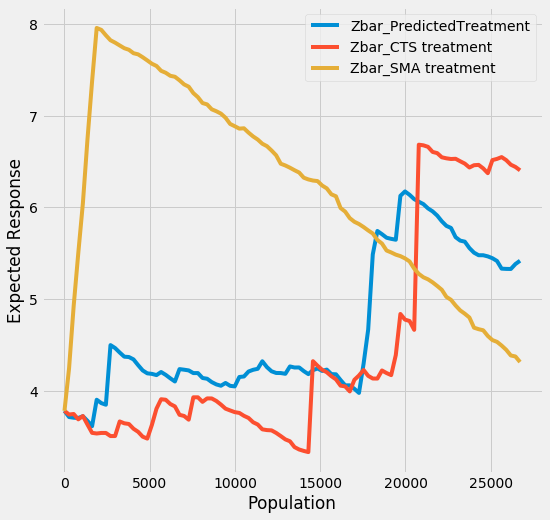

In [325]:
n=100
figsize=(8, 8)
if (n is not None) and (n < df.shape[0]):
    modified_uplift.iloc[np.linspace(0, df.index[-1], n, endpoint=True)].plot(figsize=figsize)
    plt.xlabel('Population')
    plt.ylabel('Expected Response')

In [285]:
dat_test

,lastConversionTimestamp,lastSessionTimestamp,treatment_group_key,y,converted,initScreenType_about,initScreenType_account,initScreenType_basket,initScreenType_billing,initScreenType_checkout,...,channel_EMAIL,channel_INTERNAL,channel_PAID,channel_RETARGETING,channel_SEARCH,channel_SOCIAL,hadCartAdd_False,hadCartAdd_True,clientKnown_False,clientKnown_True
18397,0.0,0.000000e+00,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
61127,0.0,0.000000e+00,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
131186,0.0,1.558167e+09,P_20,0.0,False,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
19039,0.0,0.000000e+00,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
44143,0.0,0.000000e+00,P_50,0.0,False,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108691,0.0,0.000000e+00,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
36359,0.0,1.547568e+09,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
124953,0.0,0.000000e+00,P_20,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
78801,0.0,1.560971e+09,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1


In [265]:
dat_test['treatment_group_key'].value_counts(normalize=True)

P_50           0.585164
No Discount    0.251319
P_20           0.082076
P_75           0.075864
P_25           0.005577
Name: treatment_group_key, dtype: float64

In [267]:
dat_test[dat_test['treatment_group_key'] == 'No Discount']['y'].sum()

25393.440000000002

In [169]:
dat_test[dat_test['treatment_group_key'] == 'No Discount']

,lastConversionTimestamp,lastSessionTimestamp,treatment_group_key,y,converted,initScreenType_about,initScreenType_account,initScreenType_basket,initScreenType_billing,initScreenType_checkout,...,channel_EMAIL,channel_INTERNAL,channel_PAID,channel_RETARGETING,channel_SEARCH,channel_SOCIAL,hadCartAdd_False,hadCartAdd_True,clientKnown_False,clientKnown_True
61127,0.000000e+00,0.000000e+00,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
97873,0.000000e+00,1.543410e+09,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
108069,0.000000e+00,0.000000e+00,No Discount,57.8,True,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
12744,0.000000e+00,0.000000e+00,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
108317,0.000000e+00,0.000000e+00,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47153,0.000000e+00,0.000000e+00,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
102505,0.000000e+00,0.000000e+00,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
68517,1.539328e+09,1.539328e+09,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
78801,0.000000e+00,1.560971e+09,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1


In [276]:
a = df_reverse.sort_values('SMA Uplift', ascending=True).reset_index(drop=True)
a

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment
0,P_50,8.865792,0.822055,P_25,No Discount,0.000000,0.00,P_50
1,P_50,5.213085,0.332896,P_25,No Discount,0.000000,0.00,P_50
2,P_75,9.413077,0.794813,P_25,No Discount,0.000000,0.00,P_20
3,P_75,9.413077,0.794813,P_25,No Discount,0.000000,0.00,P_50
4,P_75,9.413077,0.838670,P_20,No Discount,0.000000,0.00,P_50
...,...,...,...,...,...,...,...,...
26714,P_20,13.870506,0.838670,P_20,P_25,36.924433,35.80,P_50
26715,P_20,13.870506,0.838670,P_20,P_25,36.924433,10.90,P_50
26716,P_75,12.467143,0.557202,P_20,P_25,36.962556,39.80,P_50
26717,P_75,9.413077,0.838670,P_20,P_25,37.028494,49.90,P_50


In [277]:
prob = a['SMA treatment'].replace(tr_prob)
a['prob_SMA'] = prob
a['Zc_SMA'] = 0
a['Zc_SMA'][a['RealTreatment']=='No Discount'] = a['Real Spending']/0.251319
a['Zc_SMA1'] = a['Zc_SMA'].cumsum()

In [278]:
a

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment,prob_SMA,Zc_SMA,Zc_SMA1
0,P_50,8.865792,0.822055,P_25,No Discount,0.000000,0.00,P_50,0.251319,0.0,0.000000
1,P_50,5.213085,0.332896,P_25,No Discount,0.000000,0.00,P_50,0.251319,0.0,0.000000
2,P_75,9.413077,0.794813,P_25,No Discount,0.000000,0.00,P_20,0.251319,0.0,0.000000
3,P_75,9.413077,0.794813,P_25,No Discount,0.000000,0.00,P_50,0.251319,0.0,0.000000
4,P_75,9.413077,0.838670,P_20,No Discount,0.000000,0.00,P_50,0.251319,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
26714,P_20,13.870506,0.838670,P_20,P_25,36.924433,35.80,P_50,0.005577,0.0,101040.669428
26715,P_20,13.870506,0.838670,P_20,P_25,36.924433,10.90,P_50,0.005577,0.0,101040.669428
26716,P_75,12.467143,0.557202,P_20,P_25,36.962556,39.80,P_50,0.005577,0.0,101040.669428
26717,P_75,9.413077,0.838670,P_20,P_25,37.028494,49.90,P_50,0.005577,0.0,101040.669428


In [280]:
a[::-1]['Zc_SMA1'].reset_index(drop=True)

0        101040.669428
1        101040.669428
2        101040.669428
3        101040.669428
4        101040.669428
             ...      
26714         0.000000
26715         0.000000
26716         0.000000
26717         0.000000
26718         0.000000
Name: Zc_SMA1, Length: 26719, dtype: float64